/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


=== Summary of Random Forest Experiments ===
max_features  n_estimators  train_acc  test_acc  oob_score  mean_tree_corr
         0.3            10   0.995238  0.871111   0.824762        0.736561
         0.3            50   1.000000  0.877778   0.871429        0.737442
         0.3           100   1.000000  0.873333   0.875238        0.736213
         0.3           300   1.000000  0.873333   0.881905        0.736557
        log2            10   0.995238  0.871111   0.824762        0.736561
        log2            50   1.000000  0.877778   0.871429        0.737442
        log2           100   1.000000  0.873333   0.875238        0.736213
        log2           300   1.000000  0.873333   0.881905        0.736557
        sqrt            10   0.995238  0.871111   0.824762        0.736561
        sqrt            50   1.000000  0.877778   0.871429        0.737442
        sqrt           100   1.000000  0.873333   0.875238        0.736213
        sqrt           300   1.000000  0.873333   0.881

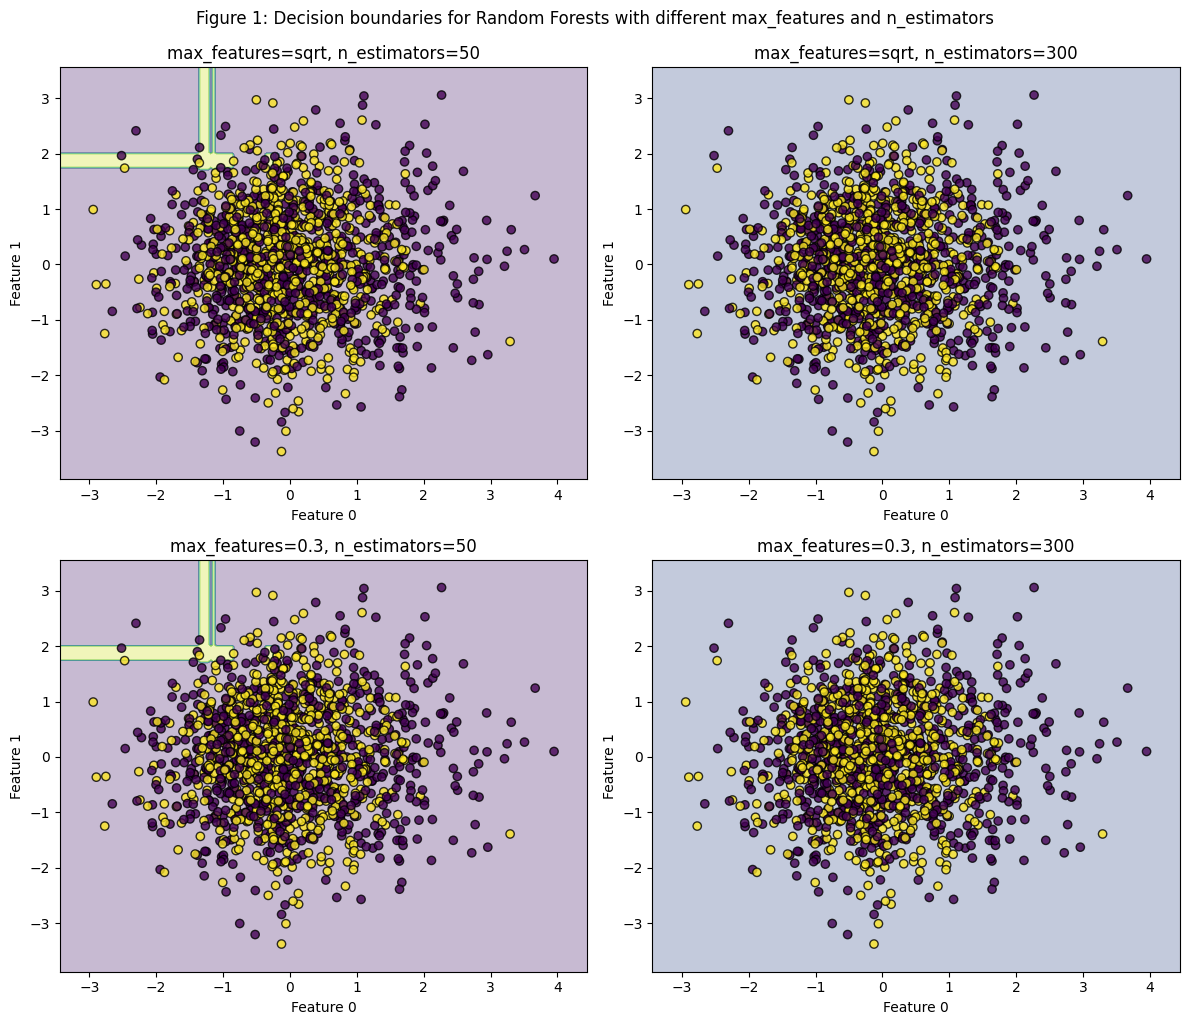

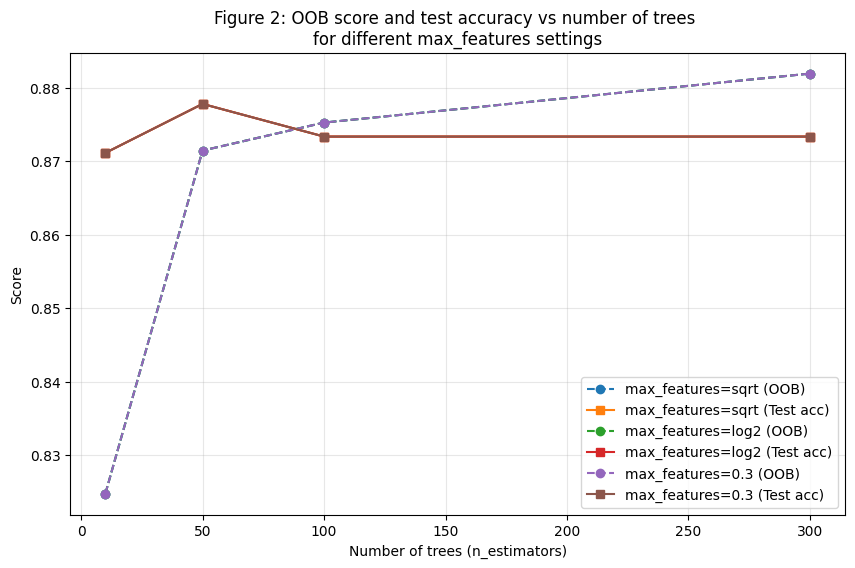

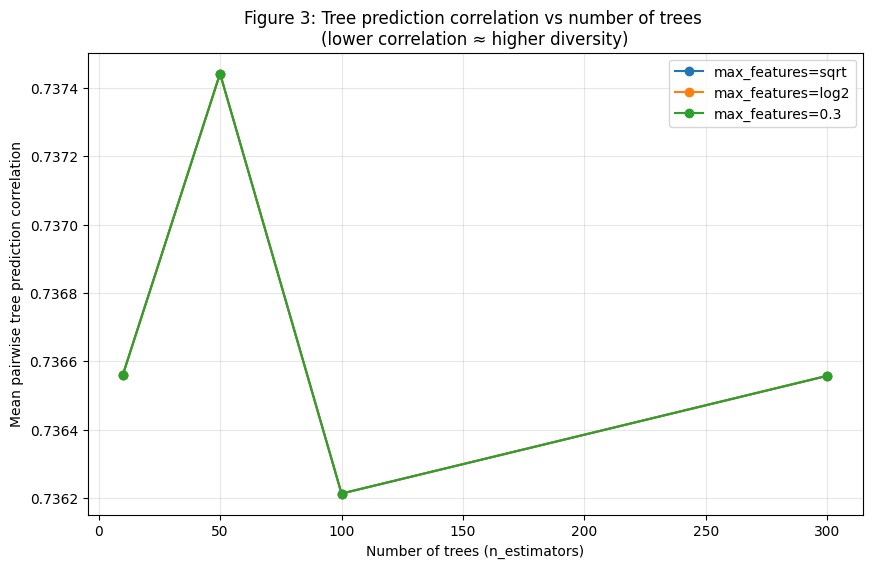

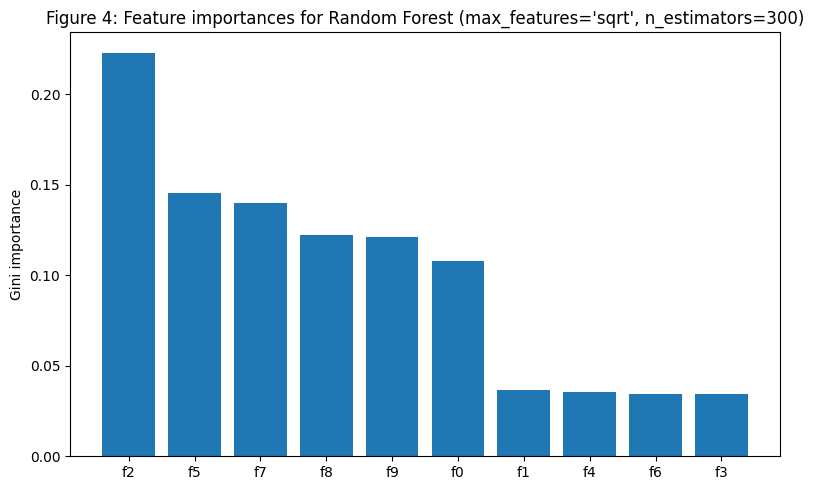

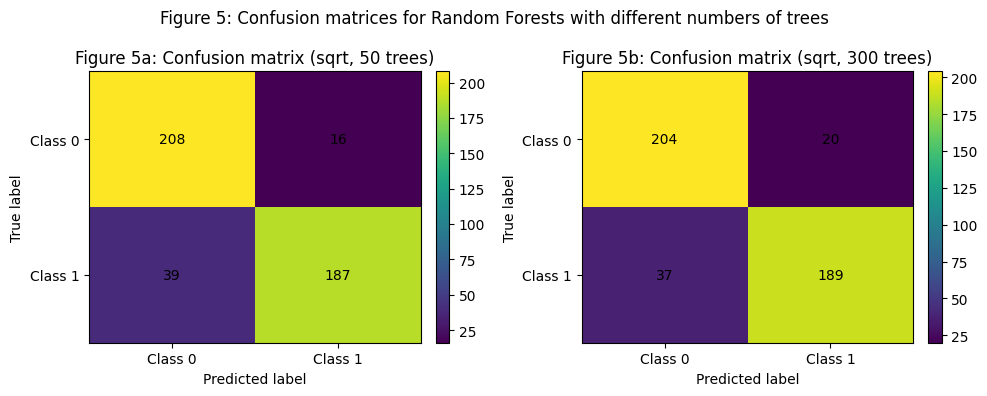


=== Compact table for report ===
max_features  n_estimators  train_acc  test_acc  oob_score  mean_tree_corr
         0.3            10   0.995238  0.871111   0.824762        0.736561
         0.3            50   1.000000  0.877778   0.871429        0.737442
         0.3           100   1.000000  0.873333   0.875238        0.736213
         0.3           300   1.000000  0.873333   0.881905        0.736557
        log2            10   0.995238  0.871111   0.824762        0.736561
        log2            50   1.000000  0.877778   0.871429        0.737442
        log2           100   1.000000  0.873333   0.875238        0.736213
        log2           300   1.000000  0.873333   0.881905        0.736557
        sqrt            10   0.995238  0.871111   0.824762        0.736561
        sqrt            50   1.000000  0.877778   0.871429        0.737442
        sqrt           100   1.000000  0.873333   0.875238        0.736213
        sqrt           300   1.000000  0.873333   0.881905        

In [ ]:
# Random Forest Deep Dive:
# Effect of n_estimators and max_features on diversity and performance
#
# Single-cell version: run this cell top-to-bottom.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------------
# 1. Data generation
# -----------------------------------------------------------
RANDOM_STATE = 42

# Create a classification dataset with some redundant & informative features
X, y = make_classification(
    n_samples=1500,
    n_features=10,
    n_informative=4,
    n_redundant=2,
    n_repeated=0,
    n_clusters_per_class=2,
    class_sep=1.2,
    flip_y=0.02,
    random_state=RANDOM_STATE,
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Standardize features (not required for RF, but helps for plots)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------------------------
# 2. Experiment grid
# -----------------------------------------------------------
n_estimators_list = [10, 50, 100, 300]
max_features_list = ["sqrt", "log2", 0.3]  # 0.3 means 30% of features

results = []

# To store some models for visualization later
stored_models = {}

# -----------------------------------------------------------
# 3. Helper: compute tree prediction correlation
# -----------------------------------------------------------
def tree_prediction_correlation(rf_model, X):
    """
    Compute average pairwise correlation between individual trees' predictions.
    Higher correlation -> less diversity inside the forest.
    """
    # Get predictions of each tree (shape: n_trees x n_samples)
    tree_preds = []
    for tree in rf_model.estimators_:
        tree_preds.append(tree.predict(X))
    tree_preds = np.array(tree_preds)  # (n_trees, n_samples)

    # Convert class labels to {0,1} for correlation
    if rf_model.n_classes_ == 2:
        tree_preds_bin = tree_preds
    else:
        # For multiclass, take prediction of one class as binary (simplification)
        tree_preds_bin = (tree_preds == 1).astype(int)

    # Correlation matrix between trees
    corr_matrix = np.corrcoef(tree_preds_bin)
    # Take upper triangle (excluding diagonal)
    n_trees = corr_matrix.shape[0]
    if n_trees < 2:
        return np.nan
    upper_idx = np.triu_indices(n_trees, k=1)
    mean_corr = np.nanmean(corr_matrix[upper_idx])
    return mean_corr

# -----------------------------------------------------------
# 4. Run experiments
# -----------------------------------------------------------
for max_features in max_features_list:
    for n_estimators in n_estimators_list:
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            oob_score=True,
            bootstrap=True,
            random_state=RANDOM_STATE,
            n_jobs=-1,
        )
        rf.fit(X_train_scaled, y_train)

        # Predictions
        y_train_pred = rf.predict(X_train_scaled)
        y_test_pred = rf.predict(X_test_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        oob = rf.oob_score_ if hasattr(rf, "oob_score_") else np.nan
        mean_tree_corr = tree_prediction_correlation(rf, X_train_scaled)

        results.append(
            {
                "max_features": max_features,
                "n_estimators": n_estimators,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "oob_score": oob,
                "mean_tree_corr": mean_tree_corr,
            }
        )

        # Store some representative models for plots
        if (max_features, n_estimators) in [
            ("sqrt", 50),
            ("sqrt", 300),
            (0.3, 50),
            (0.3, 300),
        ]:
            stored_models[(max_features, n_estimators)] = rf

# Results as DataFrame
results_df = pd.DataFrame(results)
print("=== Summary of Random Forest Experiments ===")
print(results_df.sort_values(["max_features", "n_estimators"]).to_string(index=False))

# -----------------------------------------------------------
# 5. Visualization helpers
# -----------------------------------------------------------
def plot_decision_boundary_2d(model, X, y, ax, title="", feature_indices=(0, 1)):
    """
    Plot decision boundary on 2D projection (two chosen features).
    """
    f1, f2 = feature_indices
    X_plot = X[:, [f1, f2]]

    # Create a grid
    x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
    y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200),
    )

    # Build grid points with all features = 0 except f1, f2 from grid
    X_grid = np.zeros((xx.size, X.shape[1]))
    X_grid[:, f1] = xx.ravel()
    X_grid[:, f2] = yy.ravel()

    Z = model.predict(X_grid).reshape(xx.shape)

    cs = ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(
        X_plot[:, 0], X_plot[:, 1], c=y, edgecolor="k", alpha=0.8
    )
    ax.set_xlabel(f"Feature {f1}")
    ax.set_ylabel(f"Feature {f2}")
    ax.set_title(title)


# -----------------------------------------------------------
# 6. Decision boundaries for selected models
# -----------------------------------------------------------
plt.figure(figsize=(12, 10))
plot_keys = [
    ("sqrt", 50),
    ("sqrt", 300),
    (0.3, 50),
    (0.3, 300),
]
for i, key in enumerate(plot_keys, 1):
    max_features, n_estimators = key
    rf = stored_models[key]
    ax = plt.subplot(2, 2, i)
    plot_decision_boundary_2d(
        rf,
        np.vstack([X_train_scaled, X_test_scaled]),
        np.hstack([y_train, y_test]),
        ax,
        title=f"max_features={max_features}, n_estimators={n_estimators}",
        feature_indices=(0, 1),
    )
plt.tight_layout()
plt.suptitle(
    "Figure 1: Decision boundaries for Random Forests with different max_features and n_estimators",
    y=1.02,
)
plt.show()

# -----------------------------------------------------------
# 7. OOB score and accuracy vs number of trees
# -----------------------------------------------------------
plt.figure(figsize=(10, 6))
for max_features in max_features_list:
    subset = results_df[results_df["max_features"] == max_features]
    subset = subset.sort_values("n_estimators")
    plt.plot(
        subset["n_estimators"],
        subset["oob_score"],
        marker="o",
        label=f"max_features={max_features} (OOB)",
        linestyle="--",
    )
    plt.plot(
        subset["n_estimators"],
        subset["test_acc"],
        marker="s",
        label=f"max_features={max_features} (Test acc)",
    )

plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("Score")
plt.title(
    "Figure 2: OOB score and test accuracy vs number of trees \nfor different max_features settings"
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------------------------------------
# 8. Mean tree prediction correlation vs number of trees
# -----------------------------------------------------------
plt.figure(figsize=(10, 6))
for max_features in max_features_list:
    subset = results_df[results_df["max_features"] == max_features]
    subset = subset.sort_values("n_estimators")
    plt.plot(
        subset["n_estimators"],
        subset["mean_tree_corr"],
        marker="o",
        label=f"max_features={max_features}",
    )

plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("Mean pairwise tree prediction correlation")
plt.title(
    "Figure 3: Tree prediction correlation vs number of trees \n(lower correlation ≈ higher diversity)"
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------------------------------------
# 9. Feature importance for one representative model
# -----------------------------------------------------------
# Choose a strong model: many trees, moderate feature subsampling
rep_key = ("sqrt", 300)
rep_model = stored_models[rep_key]
importances = rep_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [f"f{idx}" for idx in indices])
plt.ylabel("Gini importance")
plt.title(
    "Figure 4: Feature importances for Random Forest (max_features='sqrt', n_estimators=300)"
)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 10. Confusion matrices for two contrasting models
#      (few trees vs many trees with same max_features)
# -----------------------------------------------------------
from itertools import product

def plot_confusion_matrix(cm, classes, ax, title):
    im = ax.imshow(cm, interpolation="nearest", aspect="auto")
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    # Annotate cells
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            verticalalignment="center",
        )

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Model A: fewer trees
rf_A = stored_models[("sqrt", 50)]
y_test_pred_A = rf_A.predict(X_test_scaled)
cm_A = confusion_matrix(y_test, y_test_pred_A)

# Model B: many trees
rf_B = stored_models[("sqrt", 300)]
y_test_pred_B = rf_B.predict(X_test_scaled)
cm_B = confusion_matrix(y_test, y_test_pred_B)

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
plot_confusion_matrix(
    cm_A,
    classes=["Class 0", "Class 1"],
    ax=ax1,
    title="Figure 5a: Confusion matrix (sqrt, 50 trees)",
)

ax2 = plt.subplot(1, 2, 2)
plot_confusion_matrix(
    cm_B,
    classes=["Class 0", "Class 1"],
    ax=ax2,
    title="Figure 5b: Confusion matrix (sqrt, 300 trees)",
)

plt.suptitle(
    "Figure 5: Confusion matrices for Random Forests with different numbers of trees"
)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 11. Final compact table for report
# -----------------------------------------------------------
display_columns = [
    "max_features",
    "n_estimators",
    "train_acc",
    "test_acc",
    "oob_score",
    "mean_tree_corr",
]
print("\n=== Compact table for report ===")
print(results_df[display_columns].sort_values(["max_features", "n_estimators"]).to_string(index=False))
